<a href="https://colab.research.google.com/github/BrainConnection/Quantum_Algorithm/blob/main/1.%20TFIM%20VQE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment Setting

In [1]:
!pip install qiskit
!pip install qiskit-ibm-runtime
!pip install qiskit[visualization]
!pip install qiskit-algorithms
!pip install qiskit-aer

!pip install scipy
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 47.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 56.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 34.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.8/315.8 kB 29.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 7.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   

In [2]:
from qiskit_ibm_runtime import QiskitRuntimeService, Estimator, Options

# Save an IBM Quantum account and set it as your default account.
QiskitRuntimeService.save_account(channel="ibm_quantum",
                                  token="067e5c82606f0a1157dd554e2087d6b7a9b823dbaa4ad47b95c3337eab2e6cd9361719cc0470f4a98d1631b73b264a82577012a0b8ff32963d5964e6cc12c525",
                                  set_as_default=True,
                                  overwrite=True)

service = QiskitRuntimeService()
backend = service.backend("ibmq_qasm_simulator")

# Hamiltonian Diagonalization

$$ H = -(1-g) Σ Z_j Z_{j+1} -g Σ X_j  $$

1D 5 Qubit System

In [3]:
from qiskit.quantum_info import SparsePauliOp
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def exact_eigen_energy_open(g):
  interation = -(1-g)
  bias = -g

  coeff_list = [interation for _ in range(5)] + [bias for _ in range(5)]
  operator_list = ["ZZIII", "IZZII", "IIZZI", "IIIZZ", "ZIIIZ", "XIIII", "IXIII", "IIXII", "IIIXI", "IIIIX"]
  hamiltonian_list = []
  for i in range(10):
    hamiltonian_list.append((operator_list[i], coeff_list[i]))
  hamiltonian = SparsePauliOp.from_list(hamiltonian_list)
  hamiltonian_matrix = hamiltonian.to_matrix()

  eigenvalue, eigenvector = np.linalg.eig(hamiltonian_matrix)

  lowest_energy = np.min(eigenvalue)
  return np.real(lowest_energy)

In [5]:
def exact_eigen_energy_closed(g):
  interation = -(1-g)
  bias = -g

  coeff_list = [interation for _ in range(4)] + [bias for _ in range(5)]
  operator_list = ["ZZIII", "IZZII", "IIZZI", "IIIZZ", "XIIII", "IXIII", "IIXII", "IIIXI", "IIIIX"]
  hamiltonian_list = []
  for i in range(9):
    hamiltonian_list.append((operator_list[i], coeff_list[i]))
  hamiltonian = SparsePauliOp.from_list(hamiltonian_list)
  hamiltonian_matrix = hamiltonian.to_matrix()

  eigenvalue, eigenvector = np.linalg.eig(hamiltonian_matrix)

  lowest_energy = np.min(eigenvalue)
  return np.real(lowest_energy)

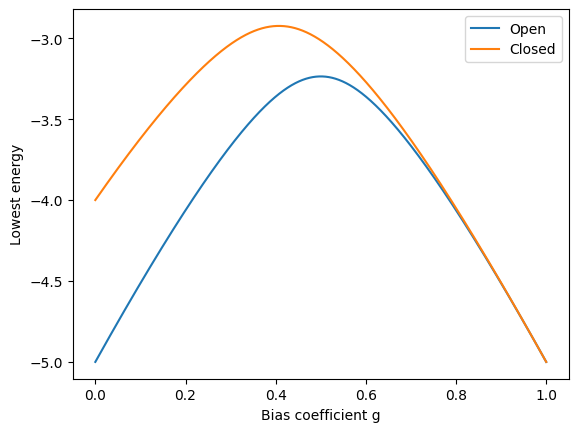

In [6]:
g_list = np.array([0.0001*g for g in range(10001)])
open_energy_list = np.array([exact_eigen_energy_open(0.0001*g) for g in range(10001)])
closed_energy_list = np.array([exact_eigen_energy_closed(0.0001*g) for g in range(10001)])

plt.figure()
plt.plot(g_list, open_energy_list, label="Open")
plt.plot(g_list, closed_energy_list, label="Closed")
plt.xlabel("Bias coefficient g")
plt.ylabel("Lowest energy")
plt.legend()

In [7]:
interation = 1
bias = -1

coeff_list = [interation for _ in range(5)] + [bias for _ in range(5)]
operator_list = ["ZZIII", "IZZII", "IIZZI", "IIIZZ", "ZIIIZ", "XIIII", "IXIII", "IIXII", "IIIXI", "IIIIX"]
hamiltonian_list = []
for i in range(10):
  hamiltonian_list.append((operator_list[i], coeff_list[i]))
hamiltonian = SparsePauliOp.from_list(hamiltonian_list)
hamiltonian_matrix = hamiltonian.to_matrix()

eigenvalue, eigenvector = np.linalg.eig(hamiltonian_matrix)

lowest_energy = np.min(eigenvalue)

np.real(lowest_energy)

-6.155367074350501

# VQE in Exact Simulator (Method 1)

quantum_algorithms VQE object

In [8]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, Parameter
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import ParameterVector
import numpy as np

# Instantiate the system Hamiltonian
interation = 1
bias = -1

coeff_list = [interation for _ in range(5)] + [bias for _ in range(5)]
operator_list = ["ZZIII", "IZZII", "IIZZI", "IIIZZ", "ZIIIZ", "XIIII", "IXIII", "IIXII", "IIIXI", "IIIIX"]
hamiltonian_list = []
for i in range(10):
    hamiltonian_list.append((operator_list[i], coeff_list[i]))
hamiltonian = SparsePauliOp.from_list(hamiltonian_list)

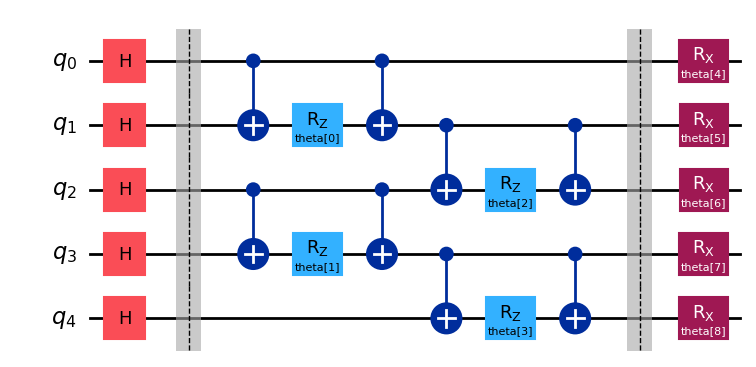

In [9]:
ansatz = QuantumCircuit(5)
params = ParameterVector("theta", length=9)
it = iter(params)
ansatz.h(range(0,5))

ansatz.barrier()

ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.rz(next(it), 1)
ansatz.rz(next(it), 3)
ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.cx(1, 2)
ansatz.cx(3, 4)
ansatz.rz(next(it), 2)
ansatz.rz(next(it), 4)
ansatz.cx(1, 2)
ansatz.cx(3, 4)

ansatz.barrier()

ansatz.rx(next(it), 0)
ansatz.rx(next(it), 1)
ansatz.rx(next(it), 2)
ansatz.rx(next(it), 3)
ansatz.rx(next(it), 4)

ansatz.draw("mpl")

In [10]:
from qiskit_algorithms.optimizers import CG
from qiskit_algorithms import VQE, SamplingVQE
from qiskit_algorithms.gradients import LinCombEstimatorGradient
from qiskit.primitives import Estimator

step_list = np.array([i for i in range(20)])
vqe_list = []

for max in range(20):

  # Conjugate Gradient algorithm
  optimizer = CG(maxiter=max)

  # Gradient callable
  estimator = Estimator()
  grad = LinCombEstimatorGradient(estimator)  # optional estimator gradient
  vqe = VQE(estimator=estimator, ansatz=ansatz, optimizer=optimizer, gradient=grad)

  result = vqe.compute_minimum_eigenvalue(hamiltonian)
  vqe_list.append(result.optimal_value)

vqe_list = np.array(vqe_list)

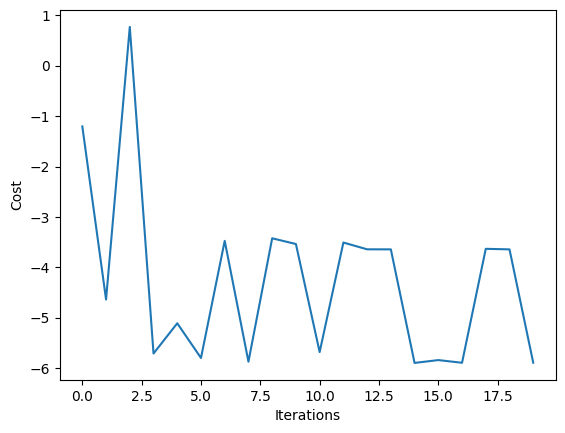

In [11]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(step_list, vqe_list)
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

# VQE in Exact Simulator (Method 2)

scipy minimize

## Function Definition

In [12]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, Parameter
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import ParameterVector
from qiskit.primitives import Estimator

import numpy as np
from scipy.optimize import minimize

In [13]:
# Instantiate the system Hamiltonian

interation = 1
bias = -1
coeff_list = [interation for _ in range(5)] + [bias for _ in range(5)]
operator_list = ["ZZIII", "IZZII", "IIZZI", "IIIZZ", "ZIIIZ", "XIIII", "IXIII", "IIXII", "IIIXI", "IIIIX"]
hamiltonian_list = []
for i in range(10):
    hamiltonian_list.append((operator_list[i], coeff_list[i]))
hamiltonian = SparsePauliOp.from_list(hamiltonian_list)


# Estimator

estimator = Estimator()

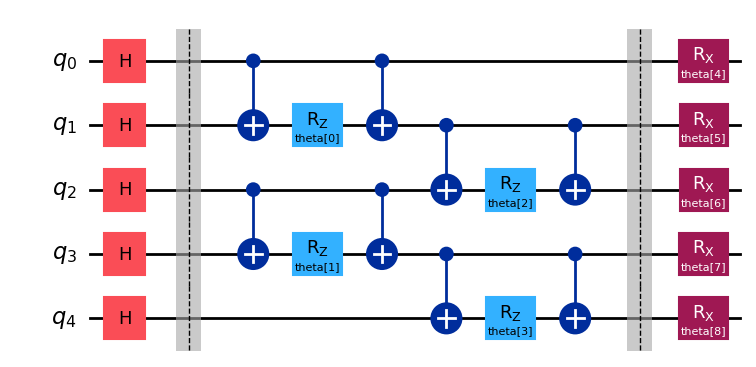

In [14]:
# Ansatz

ansatz = QuantumCircuit(5)
params = ParameterVector("theta", length=9)
it = iter(params)
ansatz.h(range(0,5))

ansatz.barrier()

ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.rz(next(it), 1)
ansatz.rz(next(it), 3)
ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.cx(1, 2)
ansatz.cx(3, 4)
ansatz.rz(next(it), 2)
ansatz.rz(next(it), 4)
ansatz.cx(1, 2)
ansatz.cx(3, 4)

ansatz.barrier()

ansatz.rx(next(it), 0)
ansatz.rx(next(it), 1)
ansatz.rx(next(it), 2)
ansatz.rx(next(it), 3)
ansatz.rx(next(it), 4)

ansatz.draw("mpl")

In [15]:
def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params).result()
    return cost.values[0]

In [16]:
def build_callback(ansatz, hamiltonian, estimator, callback_dict):
  def callback(current_vector):
    callback_dict["iters"] += 1
    callback_dict["prev_vector"] = current_vector
    current_cost = cost_func_vqe(current_vector, ansatz, hamiltonian, estimator)

    callback_dict["cost_history"].append(current_cost)

    print(
      "Iters. done: {} [Current cost: {}]".format(callback_dict["iters"], current_cost),
      end="\r",
      flush=True,
    )

  return callback

## Minimizing Method Trial

COBYLA, SLSQP, BFGS

In [17]:
callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

np.random.seed(1)
x0 = 2 * np.pi * np.random.random(9)

x0

array([2.62022653e+00, 4.52593227e+00, 7.18638172e-04, 1.89961158e+00,
       9.22094457e-01, 5.80180502e-01, 1.17030742e+00, 2.17122208e+00,
       2.49296356e+00])

In [18]:
callback = build_callback(ansatz, hamiltonian, estimator, callback_dict)
res = minimize(
  cost_func_vqe,
  x0,
  args=(ansatz, hamiltonian, estimator),
  method="cobyla",
  callback=callback,
)

In [19]:
res

 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: -5.868435164695018
       x: [ 5.840e+00  6.670e+00  3.884e-01  4.419e-01 -9.753e-01
            2.545e+00  2.181e+00  2.540e+00  2.171e+00]
    nfev: 1000
   maxcv: 0.0

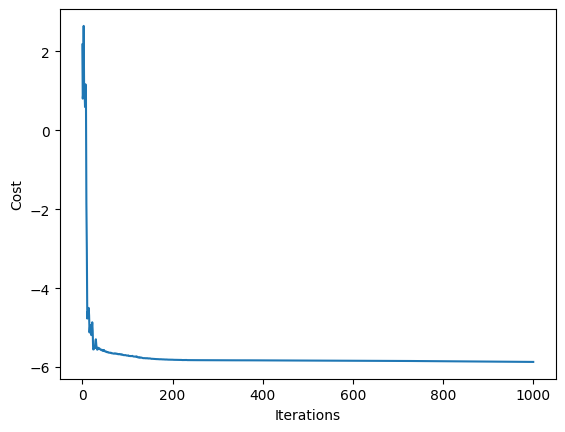

In [20]:
fig, ax = plt.subplots()
ax.plot(range(callback_dict["iters"]), callback_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

In [21]:
callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

np.random.seed(1)
x0 = 2 * np.pi * np.random.random(9)

x0

array([2.62022653e+00, 4.52593227e+00, 7.18638172e-04, 1.89961158e+00,
       9.22094457e-01, 5.80180502e-01, 1.17030742e+00, 2.17122208e+00,
       2.49296356e+00])

In [22]:
callback = build_callback(ansatz, hamiltonian, estimator, callback_dict)
res = minimize(
  cost_func_vqe,
  x0,
  args=(ansatz, hamiltonian, estimator),
  method="SLSQP",
  callback=callback,
)

In [23]:
res

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -5.897229043597868
       x: [-4.799e-01  1.296e+01  3.976e-01 -6.763e+00  1.571e+00
            4.611e-04 -1.571e+00  7.085e-04  1.570e+00]
     nit: 26
     jac: [-2.707e-04 -2.074e-04  1.443e-04 -7.766e-05  1.004e-04
            1.033e-04  1.544e-05  1.583e-04  4.572e-05]
    nfev: 262
    njev: 26

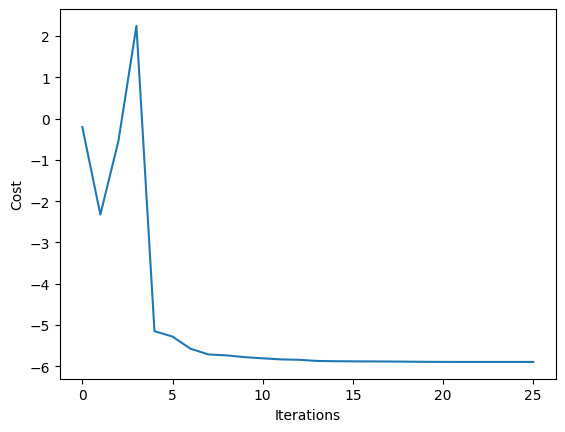

In [24]:
fig, ax = plt.subplots()
ax.plot(range(callback_dict["iters"]), callback_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

In [25]:
callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

np.random.seed(1)
x0 = 2 * np.pi * np.random.random(9)

x0

array([2.62022653e+00, 4.52593227e+00, 7.18638172e-04, 1.89961158e+00,
       9.22094457e-01, 5.80180502e-01, 1.17030742e+00, 2.17122208e+00,
       2.49296356e+00])

In [26]:
callback = build_callback(ansatz, hamiltonian, estimator, callback_dict)
res = minimize(
  cost_func_vqe,
  x0,
  args=(ansatz, hamiltonian, estimator),
  method="BFGS",
  callback=callback,
)

In [27]:
res

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -5.8972291332323294
        x: [ 4.797e-01 -3.975e-01  6.681e+00  5.803e+00 -4.712e+00
             3.142e+00  1.571e+00 -1.679e-05  1.571e+00]
      nit: 28
      jac: [ 9.060e-06 -4.709e-06 -6.557e-06  4.172e-06  5.960e-07
            -4.053e-06 -5.960e-06 -2.384e-06  2.146e-06]
 hess_inv: [[ 4.493e-01  2.554e-02 ...  4.716e-02 -1.554e-01]
            [ 2.554e-02  4.621e-01 ... -7.226e-02  1.593e-01]
            ...
            [ 4.716e-02 -7.226e-02 ...  6.165e+00 -5.498e+00]
            [-1.554e-01  1.593e-01 ... -5.498e+00  6.950e+00]]
     nfev: 340
     njev: 34

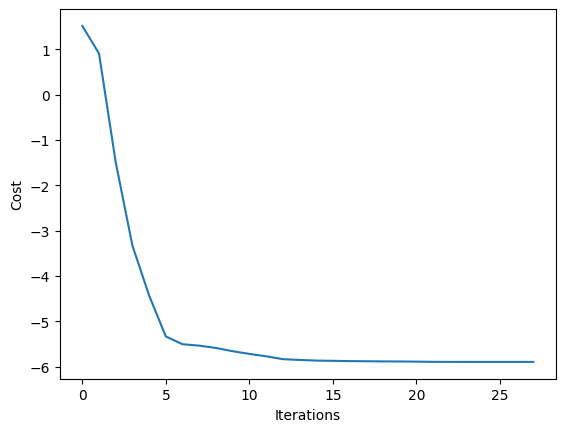

In [28]:
fig, ax = plt.subplots()
ax.plot(range(callback_dict["iters"]), callback_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

# VQE in Noisy Simulator (Trial)

scipy minimize method trial ("cobyla", "bfsd", "slsqp")

## Function Definition

In [29]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, Parameter
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import ParameterVector

import numpy as np
from scipy.optimize import minimize

from qiskit_aer.noise import NoiseModel
from qiskit_aer.primitives import Estimator

# Import from Qiskit Aer noise module
from qiskit_aer.noise import (
    NoiseModel,
    QuantumError,
    ReadoutError,
    depolarizing_error,
    pauli_error,
    thermal_relaxation_error,
)

In [30]:
# Instantiate the system Hamiltonian

interation = 1
bias = -1
coeff_list = [interation for _ in range(5)] + [bias for _ in range(5)]
operator_list = ["ZZIII", "IZZII", "IIZZI", "IIIZZ", "ZIIIZ", "XIIII", "IXIII", "IIXII", "IIIXI", "IIIIX"]
hamiltonian_list = []
for i in range(10):
    hamiltonian_list.append((operator_list[i], coeff_list[i]))
hamiltonian = SparsePauliOp.from_list(hamiltonian_list)

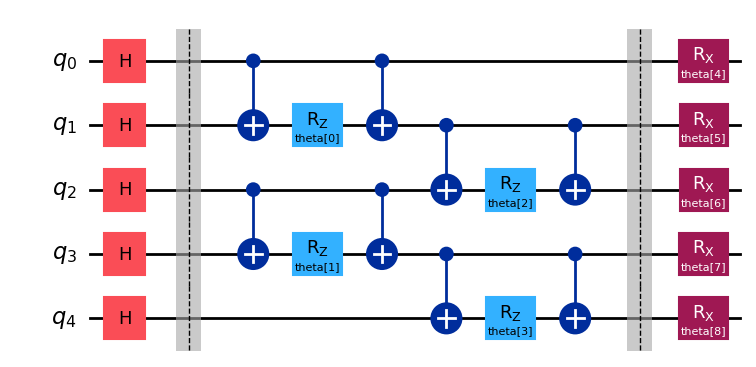

In [31]:
# Ansatz

ansatz = QuantumCircuit(5)
params = ParameterVector("theta", length=9)
it = iter(params)
ansatz.h(range(0,5))

ansatz.barrier()

ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.rz(next(it), 1)
ansatz.rz(next(it), 3)
ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.cx(1, 2)
ansatz.cx(3, 4)
ansatz.rz(next(it), 2)
ansatz.rz(next(it), 4)
ansatz.cx(1, 2)
ansatz.cx(3, 4)

ansatz.barrier()

ansatz.rx(next(it), 0)
ansatz.rx(next(it), 1)
ansatz.rx(next(it), 2)
ansatz.rx(next(it), 3)
ansatz.rx(next(it), 4)

ansatz.draw("mpl")

In [32]:
noise_model = NoiseModel()

# Example error probabilities
p_reset = 0.03
p_meas = 0.1
p_gate1 = 0.05
cx_depolarizing_prob = 0.02


# QuantumError objects
error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
error_gate1 = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
error_gate2 = error_gate1.tensor(error_gate1)

noise_model.add_all_qubit_quantum_error(error_reset, "reset")
noise_model.add_all_qubit_quantum_error(error_meas, "measure")
noise_model.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
noise_model.add_all_qubit_quantum_error(error_gate2, ["cx"])
noise_model.add_all_qubit_quantum_error(depolarizing_error(cx_depolarizing_prob, 2), ["cx"])


estimator = Estimator(backend_options={"noise_model": noise_model}, skip_transpilation=True)

print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['u2', 'cx', 'measure', 'u1', 'reset', 'u3']
  All-qubits errors: ['reset', 'measure', 'u1', 'u2', 'u3', 'cx']


In [33]:
cost = estimator.run(ansatz, hamiltonian, parameter_values=x0).result()

cost.values[0]

1.78125

In [34]:
def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params).result()
    return cost.values[0]

In [35]:
def build_callback(ansatz, hamiltonian, estimator, callback_dict):
  def callback(current_vector):
    callback_dict["iters"] += 1
    callback_dict["prev_vector"] = current_vector
    current_cost = cost_func_vqe(current_vector, ansatz, hamiltonian, estimator)

    callback_dict["cost_history"].append(current_cost)

    print(
      "Iters. done: {} [Current cost: {}]".format(callback_dict["iters"], current_cost),
      end="\r",
      flush=True,
    )

  return callback

## Minimizing Method Trial

COBYLA, SLSQP, BFGS

In [36]:
callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

np.random.seed(5)
x0 = 2 * np.pi * np.random.random(9)

x0

array([1.39482423, 5.47097243, 1.29885476, 5.77180256, 3.06877801,
       3.84370005, 4.81234099, 3.25731628, 1.86485255])

In [37]:
callback = build_callback(ansatz, hamiltonian, estimator, callback_dict)
res = minimize(
  cost_func_vqe,
  x0,
  args=(ansatz, hamiltonian, estimator),
  method="cobyla",
  callback=callback,
)

In [38]:
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -3.748046875
       x: [ 7.805e-02  6.224e+00  2.943e-01  6.670e+00  3.022e+00
            5.268e+00  4.723e+00  3.051e+00  1.793e+00]
    nfev: 100
   maxcv: 0.0

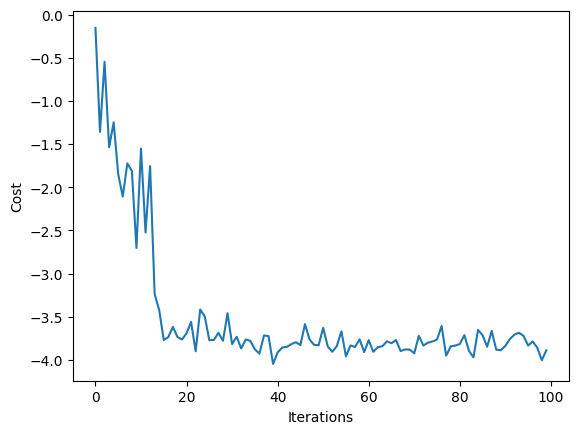

In [39]:
fig, ax = plt.subplots()
ax.plot(range(callback_dict["iters"]), callback_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

In [40]:
callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

np.random.seed(1)
x0 = 2 * np.pi * np.random.random(9)

x0

array([2.62022653e+00, 4.52593227e+00, 7.18638172e-04, 1.89961158e+00,
       9.22094457e-01, 5.80180502e-01, 1.17030742e+00, 2.17122208e+00,
       2.49296356e+00])

In [41]:
callback = build_callback(ansatz, hamiltonian, estimator, callback_dict)
res = minimize(
  cost_func_vqe,
  x0,
  args=(ansatz, hamiltonian, estimator),
  method="SLSQP",
  callback=callback,
)

In [42]:
res

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.283203125
       x: [ 4.204e+05  1.706e+06 -1.127e+06 -1.579e+06 -4.695e+05
           -5.671e+05  1.901e+05 -1.030e+06 -7.450e+05]
     nit: 51
     jac: [-1.704e+06  5.767e+06  1.560e+07 -4.194e+06 -1.573e+06
            6.029e+06  1.311e+05  9.175e+05  4.456e+06]
    nfev: 1020
    njev: 51

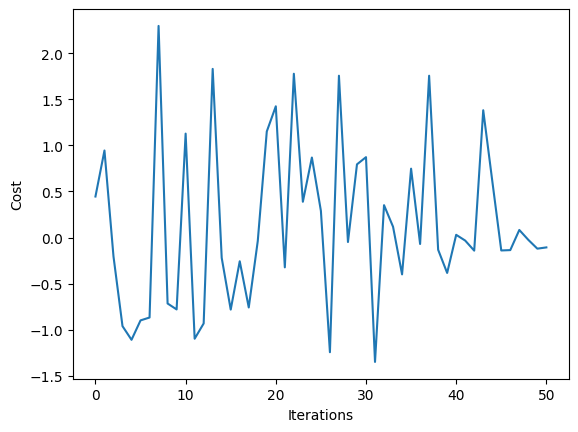

In [43]:
fig, ax = plt.subplots()
ax.plot(range(callback_dict["iters"]), callback_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

In [44]:
callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

np.random.seed(1)
x0 = 2 * np.pi * np.random.random(9)

x0

array([2.62022653e+00, 4.52593227e+00, 7.18638172e-04, 1.89961158e+00,
       9.22094457e-01, 5.80180502e-01, 1.17030742e+00, 2.17122208e+00,
       2.49296356e+00])

In [45]:
callback = build_callback(ansatz, hamiltonian, estimator, callback_dict)
res = minimize(
  cost_func_vqe,
  x0,
  args=(ansatz, hamiltonian, estimator),
  method="BFGS",
  callback=callback,
)

In [46]:
res

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 1.69140625
        x: [ 2.620e+00  4.526e+00  7.233e-04  1.900e+00  9.221e-01
             5.802e-01  1.170e+00  2.171e+00  2.493e+00]
      nit: 5
      jac: [ 3.801e+06  2.097e+07 -1.835e+06  2.569e+07  1.756e+07
             8.651e+06 -1.704e+06  2.123e+07  1.756e+07]
 hess_inv: [[ 3.770e+01  1.020e+01 ... -2.222e+01  2.896e+01]
            [ 1.020e+01  3.035e+00 ... -6.318e+00  7.739e+00]
            ...
            [-2.222e+01 -6.318e+00 ...  1.397e+01 -1.764e+01]
            [ 2.896e+01  7.739e+00 ... -1.764e+01  2.346e+01]]
     nfev: 333
     njev: 31

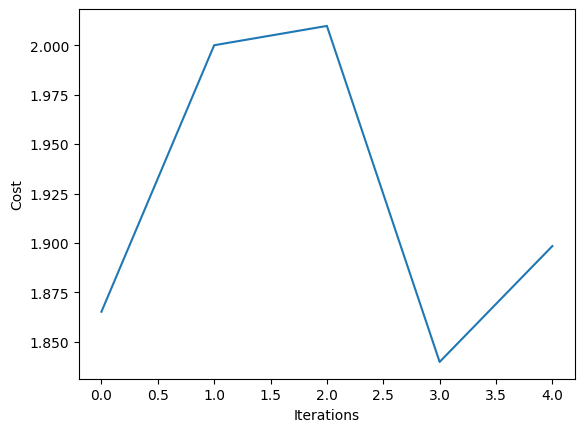

In [47]:
fig, ax = plt.subplots()
ax.plot(range(callback_dict["iters"]), callback_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

# VQE in Noisy Simulator (Various types of error)

scipy minimize method "cobyla"

## Function Setting

In [48]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, Parameter, ParameterVector

import numpy as np
from scipy.optimize import minimize

from qiskit_aer.noise import NoiseModel
from qiskit_aer.primitives import Estimator

# Import from Qiskit Aer noise module
from qiskit_aer.noise import (
    NoiseModel,
    QuantumError,
    ReadoutError,
    depolarizing_error,
    pauli_error,
    thermal_relaxation_error,
)

In [49]:
# Instantiate the system Hamiltonian

interation = 1
bias = -1
coeff_list = [interation for _ in range(5)] + [bias for _ in range(5)]
operator_list = ["ZZIII", "IZZII", "IIZZI", "IIIZZ", "ZIIIZ", "XIIII", "IXIII", "IIXII", "IIIXI", "IIIIX"]
hamiltonian_list = []
for i in range(10):
    hamiltonian_list.append((operator_list[i], coeff_list[i]))
hamiltonian = SparsePauliOp.from_list(hamiltonian_list)

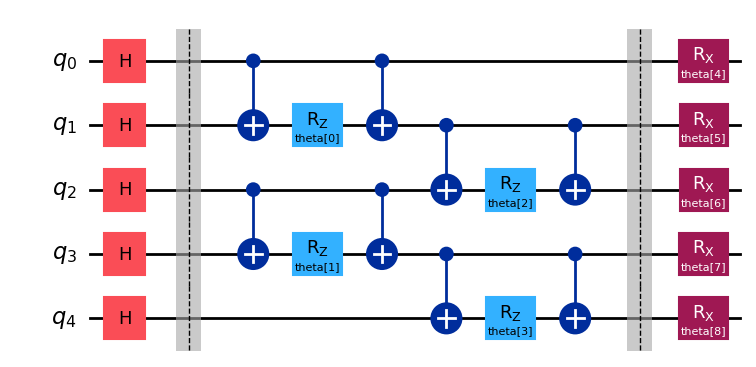

In [50]:
# Ansatz

ansatz = QuantumCircuit(5)
params = ParameterVector("theta", length=9)
it = iter(params)
ansatz.h(range(0,5))

ansatz.barrier()

ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.rz(next(it), 1)
ansatz.rz(next(it), 3)
ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.cx(1, 2)
ansatz.cx(3, 4)
ansatz.rz(next(it), 2)
ansatz.rz(next(it), 4)
ansatz.cx(1, 2)
ansatz.cx(3, 4)

ansatz.barrier()

ansatz.rx(next(it), 0)
ansatz.rx(next(it), 1)
ansatz.rx(next(it), 2)
ansatz.rx(next(it), 3)
ansatz.rx(next(it), 4)

ansatz.draw("mpl")

In [51]:
service = QiskitRuntimeService()
backend = service.backend("ibmq_qasm_simulator")

## Ideal Simulator

In [77]:
noise_model = NoiseModel()

estimator = Estimator(backend_options={"noise_model": noise_model}, skip_transpilation=True)

In [78]:
def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params, shots=8000, seed=1).result()
    return cost.values[0]


def build_callback(ansatz, hamiltonian, estimator, callback_dict):
  def callback(current_vector):
    callback_dict["iters"] += 1
    callback_dict["prev_vector"] = current_vector
    current_cost = cost_func_vqe(current_vector, ansatz, hamiltonian, estimator)

    callback_dict["cost_history"].append(current_cost)

    print(
      "Iters. done: {} [Current cost: {}]".format(callback_dict["iters"], current_cost),
      end="\r",
      flush=True,
    )

  return callback

In [79]:
seed_list = [1,4,5,6,8,13,14,15,17,18,19,20,21,23,24,25,30,31,34,36,38,39,41,42,43,45,47,48,49,51]

local_minimum_list = []

for k in range(30):

  callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
  }

  np.random.seed(seed_list[k])
  x0 = 2 * np.pi * np.random.random(9)

  callback = build_callback(ansatz, hamiltonian, estimator, callback_dict)

  options = dict()
  options["maxiter"] = 400
  options["disp"] = True

  res = minimize(
    cost_func_vqe,
    x0,
    args=(ansatz, hamiltonian, estimator),
    method="cobyla",
    callback=callback,
    options=options
  )

  local_minimum_dict = callback_dict["cost_history"]
  local_minimum_list.append(local_minimum_dict[-1])


local_minimum_list = np.array(local_minimum_list)

In [80]:
mean_ideal = np.mean(local_minimum_list)
var_ideal = np.var(local_minimum_list)
max_ideal = np.max(local_minimum_list)
min_ideal = np.min(local_minimum_list)

print("mean : {0}".format(mean_ideal))
print("variance : {0}".format(var_ideal))
print("maximum : {0}".format(max_ideal))
print("minimum : {0}".format(min_ideal))
print()
print(local_minimum_list)

mean : -5.75955
variance : 0.011339422500000007
maximum : -5.518
minimum : -5.909

[-5.909  -5.902  -5.7035 -5.8555 -5.904  -5.6995 -5.8005 -5.841  -5.8665
 -5.7225 -5.518  -5.883  -5.683  -5.8415 -5.6545 -5.6875 -5.7025 -5.641
 -5.8055 -5.6395 -5.6365 -5.8395 -5.8745 -5.853  -5.8515 -5.5505 -5.7645
 -5.7045 -5.691  -5.761 ]


## Reset Error

In [81]:
noise_model = NoiseModel()

# Example error probabilities
p_reset = 0.01

# QuantumError objects
noise_model.add_all_qubit_quantum_error(pauli_error([('X', p_reset), ('I', 1 - p_reset)]), "reset")


estimator = Estimator(backend_options={"noise_model": noise_model}, skip_transpilation=True)

In [82]:
def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params, shots=8000, seed=1).result()
    return cost.values[0]


def build_callback(ansatz, hamiltonian, estimator, callback_dict):
  def callback(current_vector):
    callback_dict["iters"] += 1
    callback_dict["prev_vector"] = current_vector
    current_cost = cost_func_vqe(current_vector, ansatz, hamiltonian, estimator)

    callback_dict["cost_history"].append(current_cost)

    print(
      "Iters. done: {} [Current cost: {}]".format(callback_dict["iters"], current_cost),
      end="\r",
      flush=True,
    )

  return callback

In [83]:
seed_list = [1,4,5,6,8,13,14,15,17,18,19,20,21,23,24,25,30,31,34,36,38,39,41,42,43,45,47,48,49,51]

local_minimum_list = []

for k in range(30):

  callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
  }

  np.random.seed(seed_list[k])
  x0 = 2 * np.pi * np.random.random(9)

  callback = build_callback(ansatz, hamiltonian, estimator, callback_dict)

  options = dict()
  options["maxiter"] = 400
  options["disp"] = True

  res = minimize(
    cost_func_vqe,
    x0,
    args=(ansatz, hamiltonian, estimator),
    method="cobyla",
    callback=callback,
    options=options
  )

  local_minimum_dict = callback_dict["cost_history"]
  local_minimum_list.append(local_minimum_dict[-1])


local_minimum_list = np.array(local_minimum_list)

In [84]:
mean_rst = np.mean(local_minimum_list)
var_rst = np.var(local_minimum_list)
max_rst = np.max(local_minimum_list)
min_rst = np.min(local_minimum_list)

print("mean : {0}".format(mean_rst))
print("variance : {0}".format(var_rst))
print("maximum : {0}".format(max_rst))
print("minimum : {0}".format(min_rst))
print()
print(local_minimum_list)

mean : -5.75955
variance : 0.011339422500000007
maximum : -5.518
minimum : -5.909

[-5.909  -5.902  -5.7035 -5.8555 -5.904  -5.6995 -5.8005 -5.841  -5.8665
 -5.7225 -5.518  -5.883  -5.683  -5.8415 -5.6545 -5.6875 -5.7025 -5.641
 -5.8055 -5.6395 -5.6365 -5.8395 -5.8745 -5.853  -5.8515 -5.5505 -5.7645
 -5.7045 -5.691  -5.761 ]


## Measurement Error

In [85]:
noise_model = NoiseModel()

# Example error probabilities
p_measure = 0.01

# QuantumError objects
noise_model.add_all_qubit_quantum_error(pauli_error([('X', p_measure), ('I', 1 - p_measure)]), "measure")


estimator = Estimator(backend_options={"noise_model": noise_model}, skip_transpilation=True)

In [86]:
def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params, shots=8000, seed=1).result()
    return cost.values[0]


def build_callback(ansatz, hamiltonian, estimator, callback_dict):
  def callback(current_vector):
    callback_dict["iters"] += 1
    callback_dict["prev_vector"] = current_vector
    current_cost = cost_func_vqe(current_vector, ansatz, hamiltonian, estimator)

    callback_dict["cost_history"].append(current_cost)

    print(
      "Iters. done: {} [Current cost: {}]".format(callback_dict["iters"], current_cost),
      end="\r",
      flush=True,
    )

  return callback

In [87]:
seed_list = [1,4,5,6,8,13,14,15,17,18,19,20,21,23,24,25,30,31,34,36,38,39,41,42,43,45,47,48,49,51]

local_minimum_list = []

for k in range(30):

  callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
  }

  np.random.seed(seed_list[k])
  x0 = 2 * np.pi * np.random.random(9)

  callback = build_callback(ansatz, hamiltonian, estimator, callback_dict)

  options = dict()
  options["maxiter"] = 400
  options["disp"] = True

  res = minimize(
    cost_func_vqe,
    x0,
    args=(ansatz, hamiltonian, estimator),
    method="cobyla",
    callback=callback,
    options=options
  )

  local_minimum_dict = callback_dict["cost_history"]
  local_minimum_list.append(local_minimum_dict[-1])


local_minimum_list = np.array(local_minimum_list)

In [88]:
mean_measure = np.mean(local_minimum_list)
var_measure = np.var(local_minimum_list)
max_measure = np.max(local_minimum_list)
min_measure = np.min(local_minimum_list)

print("mean : {0}".format(mean_measure))
print("variance : {0}".format(var_measure))
print("maximum : {0}".format(max_measure))
print("minimum : {0}".format(min_measure))
print()
print(local_minimum_list)

mean : -5.599258333333333
variance : 0.011610756180555539
maximum : -5.38625
minimum : -5.760249999999999

[-5.53625 -5.68475 -5.59475 -5.49625 -5.74475 -5.62575 -5.527   -5.70025
 -5.72475 -5.5195  -5.397   -5.76025 -5.4975  -5.69775 -5.5185  -5.58225
 -5.53425 -5.502   -5.68775 -5.5315  -5.5245  -5.701   -5.71075 -5.6695
 -5.72925 -5.40775 -5.61675 -5.691   -5.38625 -5.67825]


## Bit Flip

In [89]:
noise_model = NoiseModel()

# Example error probabilities
p_bit = 0.01

bit1 = pauli_error([('X', p_bit), ('I', 1 - p_bit)])
bit2 = bit1.tensor(bit1)

# QuantumError objects
noise_model.add_all_qubit_quantum_error(bit1, ["u1", "u2", "u3"])
noise_model.add_all_qubit_quantum_error(bit2, ["cx"])


estimator = Estimator(backend_options={"noise_model": noise_model}, skip_transpilation=True)

In [90]:
def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params, shots=8000, seed=1).result()
    return cost.values[0]


def build_callback(ansatz, hamiltonian, estimator, callback_dict):
  def callback(current_vector):
    callback_dict["iters"] += 1
    callback_dict["prev_vector"] = current_vector
    current_cost = cost_func_vqe(current_vector, ansatz, hamiltonian, estimator)

    callback_dict["cost_history"].append(current_cost)

    print(
      "Iters. done: {} [Current cost: {}]".format(callback_dict["iters"], current_cost),
      end="\r",
      flush=True,
    )

  return callback

In [91]:
seed_list = [1,4,5,6,8,13,14,15,17,18,19,20,21,23,24,25,30,31,34,36,38,39,41,42,43,45,47,48,49,51]

local_minimum_list = []

for k in range(30):

  callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
  }

  np.random.seed(seed_list[k])
  x0 = 2 * np.pi * np.random.random(9)

  callback = build_callback(ansatz, hamiltonian, estimator, callback_dict)

  options = dict()
  options["maxiter"] = 400
  options["disp"] = True

  res = minimize(
    cost_func_vqe,
    x0,
    args=(ansatz, hamiltonian, estimator),
    method="cobyla",
    callback=callback,
    options=options
  )

  local_minimum_dict = callback_dict["cost_history"]
  local_minimum_list.append(local_minimum_dict[-1])


local_minimum_list = np.array(local_minimum_list)

In [92]:
mean_bit = np.mean(local_minimum_list)
var_bit = np.var(local_minimum_list)
max_bit = np.max(local_minimum_list)
min_bit = np.min(local_minimum_list)

print("mean : {0}".format(mean_bit))
print("variance : {0}".format(var_bit))
print("maximum : {0}".format(max_bit))
print("minimum : {0}".format(min_bit))
print()
print(local_minimum_list)

mean : -5.671199999999999
variance : 0.006998509999999985
maximum : -5.5045
minimum : -5.793

[-5.5045 -5.593  -5.6625 -5.6435 -5.793  -5.558  -5.575  -5.7855 -5.7665
 -5.5925 -5.609  -5.738  -5.5445 -5.763  -5.65   -5.7485 -5.604  -5.539
 -5.711  -5.642  -5.6535 -5.732  -5.7475 -5.7125 -5.718  -5.6655 -5.6015
 -5.786  -5.7845 -5.712 ]


## Phase Flip

In [93]:
noise_model = NoiseModel()

# Example error probabilities
p_phase = 0.01

phase1 = pauli_error([('Z', p_phase), ('I', 1 - p_phase)])
phase2 = bit1.tensor(bit1)

# QuantumError objects
noise_model.add_all_qubit_quantum_error(phase1, ["u1", "u2", "u3"])
noise_model.add_all_qubit_quantum_error(phase2, ["cx"])


estimator = Estimator(backend_options={"noise_model": noise_model}, skip_transpilation=True)

In [94]:
def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params, shots=8000, seed=1).result()
    return cost.values[0]


def build_callback(ansatz, hamiltonian, estimator, callback_dict):
  def callback(current_vector):
    callback_dict["iters"] += 1
    callback_dict["prev_vector"] = current_vector
    current_cost = cost_func_vqe(current_vector, ansatz, hamiltonian, estimator)

    callback_dict["cost_history"].append(current_cost)

    print(
      "Iters. done: {} [Current cost: {}]".format(callback_dict["iters"], current_cost),
      end="\r",
      flush=True,
    )

  return callback

In [95]:
seed_list = [1,4,5,6,8,13,14,15,17,18,19,20,21,23,24,25,30,31,34,36,38,39,41,42,43,45,47,48,49,51]

local_minimum_list = []

for k in range(30):

  callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
  }

  np.random.seed(seed_list[k])
  x0 = 2 * np.pi * np.random.random(9)

  callback = build_callback(ansatz, hamiltonian, estimator, callback_dict)

  options = dict()
  options["maxiter"] = 400
  options["disp"] = True

  res = minimize(
    cost_func_vqe,
    x0,
    args=(ansatz, hamiltonian, estimator),
    method="cobyla",
    callback=callback,
    options=options
  )

  local_minimum_dict = callback_dict["cost_history"]
  local_minimum_list.append(local_minimum_dict[-1])


local_minimum_list = np.array(local_minimum_list)

In [96]:
mean_phase = np.mean(local_minimum_list)
var_phase = np.var(local_minimum_list)
max_phase = np.max(local_minimum_list)
min_phase = np.min(local_minimum_list)

print("mean : {0}".format(mean_phase))
print("variance : {0}".format(var_phase))
print("maximum : {0}".format(max_phase))
print("minimum : {0}".format(min_phase))
print()
print(local_minimum_list)

mean : -5.671199999999999
variance : 0.006998509999999985
maximum : -5.5045
minimum : -5.793

[-5.5045 -5.593  -5.6625 -5.6435 -5.793  -5.558  -5.575  -5.7855 -5.7665
 -5.5925 -5.609  -5.738  -5.5445 -5.763  -5.65   -5.7485 -5.604  -5.539
 -5.711  -5.642  -5.6535 -5.732  -5.7475 -5.7125 -5.718  -5.6655 -5.6015
 -5.786  -5.7845 -5.712 ]


## Depolarization

In [97]:
noise_model = NoiseModel()

# Example error probabilities
u_depolarizing_prob = 0.01
cx_depolarizing_prob = 0.01

# QuantumError objects
noise_model.add_all_qubit_quantum_error(depolarizing_error(u_depolarizing_prob, 1), ['u1', 'u2', 'u3'])
noise_model.add_all_qubit_quantum_error(depolarizing_error(cx_depolarizing_prob, 2), ["cx"])

estimator = Estimator(backend_options={"noise_model": noise_model}, skip_transpilation=True)

In [98]:
def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params, shots=8000, seed=1).result()
    return cost.values[0]


def build_callback(ansatz, hamiltonian, estimator, callback_dict):
  def callback(current_vector):
    callback_dict["iters"] += 1
    callback_dict["prev_vector"] = current_vector
    current_cost = cost_func_vqe(current_vector, ansatz, hamiltonian, estimator)

    callback_dict["cost_history"].append(current_cost)

    print(
      "Iters. done: {} [Current cost: {}]".format(callback_dict["iters"], current_cost),
      end="\r",
      flush=True,
    )

  return callback

In [99]:
seed_list = [1,4,5,6,8,13,14,15,17,18,19,20,21,23,24,25,30,31,34,36,38,39,41,42,43,45,47,48,49,51]

local_minimum_list = []

for k in range(30):

  callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
  }

  np.random.seed(seed_list[k])
  x0 = 2 * np.pi * np.random.random(9)

  callback = build_callback(ansatz, hamiltonian, estimator, callback_dict)

  options = dict()
  options["maxiter"] = 400
  options["disp"] = True

  res = minimize(
    cost_func_vqe,
    x0,
    args=(ansatz, hamiltonian, estimator),
    method="cobyla",
    callback=callback,
    options=options
  )

  local_minimum_dict = callback_dict["cost_history"]
  local_minimum_list.append(local_minimum_dict[-1])


local_minimum_list = np.array(local_minimum_list)

In [100]:
mean_depo = np.mean(local_minimum_list)
var_depo = np.var(local_minimum_list)
max_depo = np.max(local_minimum_list)
min_depo = np.min(local_minimum_list)

print("mean : {0}".format(mean_depo))
print("variance : {0}".format(var_depo))
print("maximum : {0}".format(max_depo))
print("minimum : {0}".format(min_depo))
print()
print(local_minimum_list)

mean : -5.562125
variance : 0.01060742395833334
maximum : -5.356999999999999
minimum : -5.714

[-5.463   -5.407   -5.505   -5.62    -5.714   -5.63525 -5.5155  -5.6955
 -5.694   -5.5115  -5.55    -5.685   -5.43575 -5.67375 -5.47575 -5.51175
 -5.5525  -5.4255  -5.61325 -5.534   -5.41675 -5.6175  -5.6775  -5.62425
 -5.6595  -5.357   -5.40125 -5.651   -5.62425 -5.61675]


## Summation of all-type Error & Conclusion

In [101]:
noise_model = NoiseModel()

# Example error probabilities
p_reset = 0.01
p_measure = 0.01
p_bit = 0.01
p_phase = 0.01
u_depolarizing_prob = 0.01
cx_depolarizing_prob = 0.01

bit1 = pauli_error([('X', p_bit), ('I', 1 - p_bit)])
bit2 = bit1.tensor(bit1)

phase1 = pauli_error([('Z', p_phase), ('I', 1 - p_phase)])
phase2 = bit1.tensor(bit1)

# QuantumError objects
noise_model.add_all_qubit_quantum_error(pauli_error([('X', p_reset), ('I', 1 - p_reset)]), "reset")

noise_model.add_all_qubit_quantum_error(pauli_error([('X', p_measure), ('I', 1 - p_measure)]), "measure")

noise_model.add_all_qubit_quantum_error(bit1, ["u1", "u2", "u3"])
noise_model.add_all_qubit_quantum_error(bit2, ["cx"])

noise_model.add_all_qubit_quantum_error(phase1, ["u1", "u2", "u3"])
noise_model.add_all_qubit_quantum_error(phase2, ["cx"])

noise_model.add_all_qubit_quantum_error(depolarizing_error(u_depolarizing_prob, 1), ['u1', 'u2', 'u3'])
noise_model.add_all_qubit_quantum_error(depolarizing_error(cx_depolarizing_prob, 2), ["cx"])

estimator = Estimator(backend_options={"noise_model": noise_model}, skip_transpilation=True)

In [102]:
def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params, shots=8000, seed=1).result()
    return cost.values[0]


def build_callback(ansatz, hamiltonian, estimator, callback_dict):
  def callback(current_vector):
    callback_dict["iters"] += 1
    callback_dict["prev_vector"] = current_vector
    current_cost = cost_func_vqe(current_vector, ansatz, hamiltonian, estimator)

    callback_dict["cost_history"].append(current_cost)

    print(
      "Iters. done: {} [Current cost: {}]".format(callback_dict["iters"], current_cost),
      end="\r",
      flush=True,
    )

  return callback

In [103]:
seed_list = [1,4,5,6,8,13,14,15,17,18,19,20,21,23,24,25,30,31,34,36,38,39,41,42,43,45,47,48,49,51]

local_minimum_list = []

for k in range(30):

  callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
  }

  np.random.seed(seed_list[k])
  x0 = 2 * np.pi * np.random.random(9)

  callback = build_callback(ansatz, hamiltonian, estimator, callback_dict)

  options = dict()
  options["maxiter"] = 400
  options["disp"] = True

  res = minimize(
    cost_func_vqe,
    x0,
    args=(ansatz, hamiltonian, estimator),
    method="cobyla",
    callback=callback,
    options=options
  )

  local_minimum_dict = callback_dict["cost_history"]
  local_minimum_list.append(local_minimum_dict[-1])


local_minimum_list = np.array(local_minimum_list)

In [104]:
mean_all = np.mean(local_minimum_list)
var_all = np.var(local_minimum_list)
max_all = np.max(local_minimum_list)
min_all = np.min(local_minimum_list)

print("mean : {0}".format(mean_all))
print("variance : {0}".format(var_all))
print("maximum : {0}".format(max_all))
print("minimum : {0}".format(min_all))
print()
print(local_minimum_list)

mean : -5.237808333333334
variance : 0.005346844513888881
maximum : -5.10725
minimum : -5.37425

[-5.2055  -5.328   -5.19725 -5.10725 -5.35875 -5.21525 -5.2295  -5.37425
 -5.31575 -5.17525 -5.191   -5.3115  -5.22125 -5.28725 -5.22375 -5.1855
 -5.2135  -5.1415  -5.319   -5.24    -5.288   -5.3195  -5.127   -5.268
 -5.3135  -5.2565  -5.156   -5.293   -5.138   -5.13375]


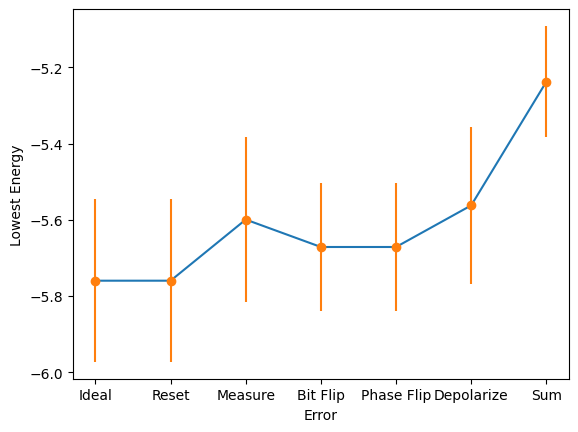

In [107]:
import matplotlib.pyplot as plt

x = ["Ideal", "Reset", "Measure", "Bit Flip", "Phase Flip", "Depolarize", "Sum"]
y = [mean_ideal, mean_rst, mean_measure, mean_bit, mean_phase, mean_depo, mean_all]
yerr = [2*np.sqrt(var_ideal), 2*np.sqrt(var_rst), 2*np.sqrt(var_measure), 2*np.sqrt(var_bit), 2*np.sqrt(var_phase), 2*np.sqrt(var_depo), 2*np.sqrt(var_all)]

plt.plot(x, y)
plt.errorbar(x, y, yerr=yerr, fmt ='o')
plt.xlabel('Error')
plt.ylabel('Lowest Energy')
plt.show()

# VQE in IBM Hardware (Least Busy)

optimization_level = 3
resilence_level = 1
seed = 6

In [ ]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, Parameter
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import ParameterVector

from qiskit_ibm_runtime import QiskitRuntimeService, Estimator, Options
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

import numpy as np
from scipy.optimize import minimize

In [ ]:
# Instantiate the system Hamiltonian

interation = 1
bias = -1
coeff_list = [interation for _ in range(5)] + [bias for _ in range(5)]
operator_list = ["ZZIII", "IZZII", "IIZZI", "IIIZZ", "ZIIIZ", "XIIII", "IXIII", "IIXII", "IIIXI", "IIIIX"]
hamiltonian_list = []
for i in range(10):
    hamiltonian_list.append((operator_list[i], coeff_list[i]))
hamiltonian = SparsePauliOp.from_list(hamiltonian_list)

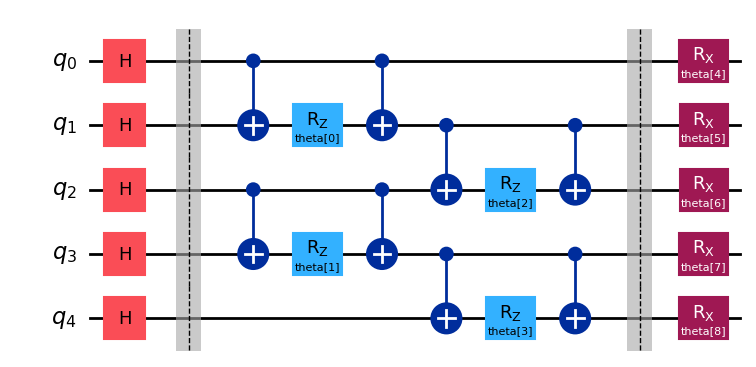

In [ ]:
# Ansatz

ansatz = QuantumCircuit(5)
params = ParameterVector("theta", length=9)
it = iter(params)
ansatz.h(range(0,5))

ansatz.barrier()

ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.rz(next(it), 1)
ansatz.rz(next(it), 3)
ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.cx(1, 2)
ansatz.cx(3, 4)
ansatz.rz(next(it), 2)
ansatz.rz(next(it), 4)
ansatz.cx(1, 2)
ansatz.cx(3, 4)

ansatz.barrier()

ansatz.rx(next(it), 0)
ansatz.rx(next(it), 1)
ansatz.rx(next(it), 2)
ansatz.rx(next(it), 3)
ansatz.rx(next(it), 4)

ansatz.draw("mpl")

In [23]:
service = QiskitRuntimeService()

backend = service.least_busy(simulator=False, operational=True)
print(backend)

<IBMBackend('ibm_nazca')>


In [24]:
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(ansatz)
isa_observable = hamiltonian.apply_layout(isa_circuit.layout)

options = Options()
options.optimization_level = 3
options.resilience_level = 1

estimator = Estimator(backend=backend, options=options)

In [ ]:
def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params).result()
    return cost.values[0]

In [26]:
def build_callback(ansatz, hamiltonian, estimator, callback_dict):
  def callback(current_vector):
    callback_dict["iters"] += 1
    callback_dict["prev_vector"] = current_vector
    current_cost = cost_func_vqe(current_vector, ansatz, hamiltonian, estimator)

    callback_dict["cost_history"].append(current_cost)

    print(
      "Iters. done: {} [Current cost: {}]".format(callback_dict["iters"], current_cost),
      end="\r",
      flush=True,
    )

  return callback

In [59]:
callback_dict = {
  "prev_vector": None,
  "iters": 0,
  "cost_history": [],
}

np.random.seed(6)
x0 = 2 * np.pi * np.random.random(9)

callback = build_callback(isa_circuit, isa_observable, estimator, callback_dict)
options = dict()
options["maxiter"] = 400
options["disp"] = True

res = minimize(
  cost_func_vqe,
  x0,
  args=(isa_circuit, isa_observable, estimator),
  method="cobyla",
  callback=callback,
  options=options
)

ERROR:websocket:Connection to remote host was lost. - goodbye
ERROR:websocket:Connection to remote host was lost. - goodbye
ERROR:websocket:Connection to remote host was lost. - goodbye
ERROR:websocket:Connection to remote host was lost. - goodbye
ERROR:websocket:Connection to remote host was lost. - goodbye
ERROR:websocket:Connection to remote host was lost. - goodbye
runtime_job._start_websocket_client:WARNING:2024-03-06 12:16:17,681: An error occurred while streaming results from the server for job cqkvc9sz09fg008mfb0g:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/qiskit_ibm_runtime/runtime_job.py", line 549, in _start_websocket_client
    self._ws_client.job_results()
  File "/usr/local/lib/python3.10/dist-packages/qiskit_ibm_runtime/api/clients/runtime_ws.py", line 70, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/usr/local/lib/python3.10/dist-packages/qiskit_ibm_runtime/api/clients/base_w

KeyboardInterrupt: 

In [ ]:
res

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(callback_dict["iters"]), callback_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()